In [1]:
%load_ext autoreload
%autoreload 2

## QSO Selection Completeness Metric
</br> **Last Run:** 02/23/21
</br> __Description:__ This notebook implement a metric to evaluate QSO selection completeness given a set of particular selection criteria using the simulated QSOs provided by JT.

### 0. Software Setup

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import glob
import os

In [3]:
# automatically extract username
your_username = os.getcwd().split('/')[5]
print(f'Your automatically extracted username is: {your_username}.'
        '\nIf it is incorrect, please mannually reset it.')

Your automatically extracted username is: ywx649999311.
If it is incorrect, please mannually reset it.


##### Import the sims_maf modules needed.

In [4]:
# import lsst.sim.maf moduels modules
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
from lsst.sims.maf.stackers import BaseStacker
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

# import convenience functions
# from opsimUtils import *

### 1. Define the Metric

In [5]:
from lsst.sims.maf.metrics import BaseMetric
from lsst.sims.maf.metrics import Coaddm5Metric
import healpy as hp

class color_selection_function(BaseMetric):
    """Selection Fucntion Metricz: Evaluate compleness given selection criteria"""
    
    def __init__(self, qso_df, z_low, z_high, query, sim_y_limit=28.0, passbands=['u', 'g', 'r', 'i', 'z', 'y'], 
                 coaddm5Metric = Coaddm5Metric, m5Col="fiveSigmaDepth", metricDtype=None, **kwargs):

        """Init function.
        
        Args:
            qso_df(object): Pandas dataframe of simulated QSOs.
            z_low(float): The lower limit of the redshift range for the corresponding
                selection criteria.
            z_high(float): The upper limit of the redshift range for the corresponding
                selection criteria.
            query(str): The query for the selection criteria.
            sim_y_limit(float): The y-band depth of the simulated QSOs, i.e., only simulated QSOs that 
                are brighter than sim_y_limit will be used to determine this selection metric. 
                Defaluts to 28.0.
            passbands(object): A list passbands will be needed to for selection. Please 
                make sure to specify all bands needed, otherwise error might occur. Defaults to all.
            coaddm5Metric(object): The metric class for computing coadded 5-sigma limiting magnitude. 
                Defaluts to the norminal CoaddM5Metric. 
            m5Col(str): The column name for the 5-sigma limiting magnitude column. Defaluts to 
                "fiveSigmaDepth".
            metricDtype(str): The data type of the returned metric -- "int", "float" or "object". 
                Set it to "object" if returning an array. Defaults to None (determined by MAF). 
        """
        
        self.qso_df = qso_df
        self.z_low = z_low
        self.z_high = z_high
        self.query = query
        self.sim_y_limit = sim_y_limit
        self.passbands = passbands
        self.m5Col = m5Col
        self.filterCol = 'filter'
        self.metricName = f'color_select_{z_low}_{z_high}_Y{sim_y_limit}' # metricName by redshift range
        self.coaddm5Metric = coaddm5Metric(m5Col=self.m5Col)
        
        cols=[self.m5Col, self.filterCol]
        super(color_selection_function, self).__init__(col=cols, metricDtype=metricDtype, metricName=self.metricName, **kwargs)

    
    def run(self, dataSlice, slicePoint=None):
        """
        Test the high-z color cut from Banados 2016 to select 5.7 < z < 6.5 quasars

        :param dataSlice:
        :return:
        
        """
        
        # placeholder for 5-sigma limiting magnitude (m5), will be computed below
        m5 = {} 
        # select simulated QSOs in the provided redshift/magnitude range
        first_cut = f'({self.z_low} < z < {self.z_high}) and (LSST_Wide_y_mag < {self.sim_y_limit})'
        df_qso = self.qso_df.query(first_cut).copy('deep').reset_index(drop=True)
        
        # loop over each passband in the passbands
        for passband in self.passbands:
            
            # mask this pixel as bad if zero visit found in any passband
            if dataSlice[dataSlice['filter'] == passband].size < 1:
                return self.badval
            
            # compute 5 sigma limiting depth
            m5[passband] = self.coaddm5Metric.run(dataSlice[dataSlice['filter'] == passband])

            # create new column to store the m5 mag
            df_qso.loc[:, f'LSST_Wide_{passband}_mag_5sigma'] =  m5[passband]
            
            # subtitute simulated mag with m5depth if mag > m5depth;
            # e.g., If simulated qso has a y-band mag of 26 and the m5coadd mag in y-band is 24, 
            # the y-band mag will be replaced with 24;
            # We make this update based-on color selection criteria
            df_qso.loc[:, f'LSST_Wide_{passband}_mag_lsst'] = df_qso.loc[:, f'LSST_Wide_{passband}_mag']
            df_qso[f'LSST_Wide_{passband}_mag_lsst'].where(
                (df_qso[f'LSST_Wide_{passband}_mag_lsst'] <= m5[passband]), m5[passband], inplace=True)

#             idx = df_qso.query(f'LSST_Wide_{passband}_mag >= {m5[passband]}').index
#             df_qso.loc[idx, f'LSST_Wide_{passband}_mag_lsst'] = m5[passband]
            
        # Quasar selection color cut; criteria provided by user
        # e.g., self.query could be:
        # '(LSST_Wide_i_mag - LSST_Wide_z_mag > 2) and (LSST_Wide_z_mag - LSST_Wide_y_mag < 0.5)'
        sel = df_qso.query(self.query)
                
        # get the number of selected QSOs by given criteria 
        # and the total number in the specific redshift range
        n_qso_sel = np.int(sel.shape[0])
        n_qso = np.int(df_qso.shape[0])
        
        return n_qso_sel/n_qso

#### How to use this metric
1. Provide the simulated QSOs in a pandas dataframe.
2. Set the redshift range that your selection criteria will select QSOs from.
3. Provide the selection criteria in the SQL query format.
4. Set the simulated QSO y-band depth if desired (the simulated dataset provided by JT has QSOs up to ymag = 28)

Note on the available columns:
- z: redshift
- LSST_Wide_{band}_mag: Simulated QSO mag (untouched)
- LSST_Wide_{band}_mag_5sigma: LSST limiting mag
- LSST_Wide_{band}\_mag_lsst: Simulated QSO mag altered to match LSST depth, i.e., the smaller of LSST_Wide_{band}\_mag and LSST_Wide_{band}\_mag_5sigma.

Next, we demonstrate how to run this metric.

### 2. Run \& Plot

In [6]:
#Read in an opSim (in this case "baseline_v1.5_10yrs.db") to test the above metric 
opsdb1 = db.OpsimDatabase('/home/idies/workspace/lsst_cadence/FBS_1.5/baseline_v1.5_10yrs.db')
outDir = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/tmp/color_select'.format(your_username)
resultsDb = db.ResultsDb(outDir=outDir)

#### 2.1.1 Selection Metric

In [7]:
# load simulated QSOs
sim_path = '/home/idies/workspace/lsst_cadence/LSST_AGN/Class/Data/selsing2016_photo_Shen_qlf_1000sdeg_z5to7_y14to28_LSST_models.hdf5'
qso_df = pd.read_hdf(sim_path)


# LSST_Wide_{band}_mag_lsst are magnitudes adjusted to LSST depth, use this for selection.
# LSST_Wide_{band}_mag are the true magnitudes of the simulated QSOs, use this for determining dropout.
# color selection criteria from Banados 2016 for 5.7 < z < 6.5.
color_select_query = '(LSST_Wide_i_mag_lsst - LSST_Wide_z_mag_lsst > 2) and ' + \
                     '(LSST_Wide_z_mag_lsst - LSST_Wide_y_mag_lsst < 0.5) and' + \
                     '(LSST_Wide_u_mag > LSST_Wide_u_mag_5sigma) and ' + \
                     '(LSST_Wide_g_mag > LSST_Wide_g_mag_5sigma) and ' + \
                     '(LSST_Wide_r_mag > LSST_Wide_r_mag_5sigma)'

# create metric object
selection_metric = color_selection_function(qso_df, 5.7, 6.5, color_select_query)

# slicer = a grouping or subdivision of visits for the simulated survey
# based on their position on the sky (using a Healpix grid)
slicer = slicers.HealpixSlicer(nside=16)

# constraint = the sql query (or 'select') that selects all visits in r band
constraint = 'proposalId = 1'
constraint += ' and note not like "DD%"'

# create metric bundle to group metric, slicer and sql constraint together
selection_mb = metricBundles.MetricBundle(selection_metric, slicer, constraint)

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes


#### 2.1.2 Y-band CoaddMetric 

In [9]:
coaddYMetric = metrics.Coaddm5Metric()

# constraint = the sql query (or 'select') that selects all visits in r band
coaddYconstraint = 'proposalId = 1'
coaddYconstraint += ' and note not like "DD%"'
coaddYconstraint += ' and filter = "y"'

coaddY_mb = metricBundles.MetricBundle(coaddYMetric, slicer, coaddYconstraint)

In [10]:
# put bundle into bundle dict
bundleDict = {'selection': selection_mb, 'coaddY': coaddY_mb}

# set summary metrics
summaryMetrics = [metrics.PercentileMetric(percentile=10), metrics.MedianMetric(),
                  metrics.PercentileMetric(percentile=90)]
for mb in bundleDict:
    bundleDict[mb].setSummaryMetrics(summaryMetrics)
    
# make a group and run
group = metricBundles.MetricBundleGroup(bundleDict, opsdb1, outDir=outDir, resultsDb=resultsDb)
group.runAll()

Querying database SummaryAllProps with constraint proposalId = 1 and note not like "DD%" and filter = "y" for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec']
Found 382509 visits
Running:  ['coaddY']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint proposalId = 1 and note not like "DD%" for columns ['filter', 'fieldRA', 'fiveSigmaDepth', 'fieldDec']
Found 1851875 visits
Running:  ['selection']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/metrics/simpleMetrics.py:38: RuntimeWarning: divide by zero encountered in log10
  return 1.25 * np.log10(np.sum(10.**(.8*dataSlice[self.colname])))


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


#### 2.2.1 Plot Color_Select Metric 

In [11]:
# plots to generate for this specific metric bundle
healpixhist = plots.HealpixHistogram()
healpixSky = plots.HealpixSkyMap()
plot_funcs = [healpixSky, healpixhist]

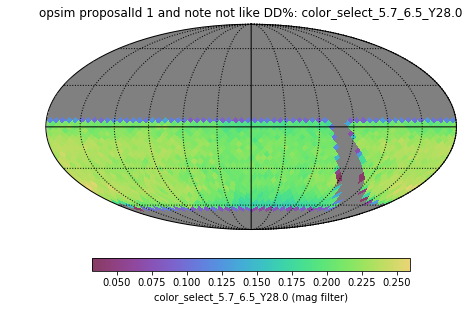

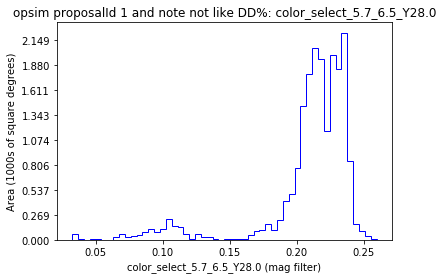

In [12]:
# loop over the plotting function defined in the first cell of section 2.2.1
for plot_func in plot_funcs:
    bundleDict['selection'].plot(plotFunc=plot_func)

##### Print out summary statistics

In [13]:
# Look at the summary values calculated - pandas DataFrame makes a nice view
pd.DataFrame(bundleDict['selection'].summaryValues, index=['Selection Metric'])

,10th%ile,Median,90th%ile
Selection Metric,0.182864,0.216708,0.235907


#### 2.2.2 Plot Y-band Coadd Depth Metric

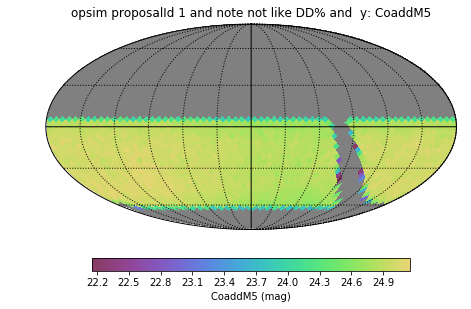

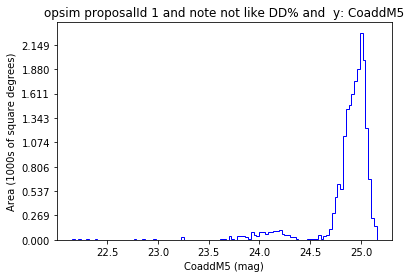

In [14]:
# loop over the plotting function defined in the first cell of section 2.2.1
for plot_func in plot_funcs:
    bundleDict['coaddY'].plot(plotFunc=plot_func)

##### Print out summary statistics

In [15]:
# Look at the summary values calculated - pandas DataFrame makes a nice view
pd.DataFrame(bundleDict['coaddY'].summaryValues, index=['CoaddM5Metric Y-band'])

,10th%ile,Median,90th%ile
CoaddM5Metric Y-band,24.731339,24.941654,25.051542


### __Note:__
The maximum completeness achievable is ~0.81 as demonstrated below (select QSOs without resetting fainter objects using limiting magnitudes): 

In [16]:
# select qsos in 5.7 < z < 6.5 without replacing fainter magnitudes with the limiting magnitude
sel_qso = qso_df.query('5.7 < z < 6.5').query('(LSST_Wide_i_mag - LSST_Wide_z_mag > 2) and (LSST_Wide_z_mag - LSST_Wide_y_mag < 0.5)')

# get total number of QSOs in 5.7 < z < 6.5
qso_in_z = qso_df.query('(5.7 < z < 6.5)')

# print number of selected QSOs vs. total number of simulated QSOs in the specified redshift range
print(f'The maximum completeness achievable: {sel_qso.shape[0]/qso_in_z.shape[0]}')

The maximum completeness achievable: 0.8112745098039216


### -----Stop Here----------

#### Make plots to examine the output

##### A few new plot functions to handle multi-output metric

In [19]:
def plotSky_MO(mb, metric_idx, dim=1, scale_func=np.copy, extra_title=''):
    '''
    Plot High-Res DDF skymap. 

    Args:
        mb: MetricBundle object.
        metric_idx(int): The index of the metric to plot in the multi-output metric
        dim (int): The number of metric values return for each pixel. Defaults to 1.
        scale_func (func): A scaling function for the metric data, e.g., np.log10. 
            Defaults to np.copy.
        extra_title(str): Title text (in addition to metric name and run name). 
    '''
    
    fig = plt.figure(dpi=120)
    try:
        mbValues = mb.metricValues.copy()
        mask = mbValues.mask
        data = mbValues.data[~mask]
        shape = (data.shape[0], dim)
        plot_data = np.concatenate(np.atleast_2d(data), axis=0).reshape(shape)[:, metric_idx]
        mbValues.data[~mask] = scale_func(plot_data)
    except Exception as e:
        print(e)
        return None
    
    _ = hp.mollview(mbValues, flip='astro')
    _ = hp.graticule(verbose=False)
    
    title = str(extra_title)
    title += f' Metric:{mb.metric.name}, RunName:{mb.runName}'
    plt.title(title)

def plotHist_MO(mb, metric_idx, xlabel, dim=1, scale_func=np.copy, extra_title=''):
    '''
    Plot High-Res DDF skymap. 

    Args:
        mb: MetricBundle object.
        metric_idx(int): The index of the metric to plot in the multi-output metric.
        dim (int): The number of metric values return for each pixel. Defaults to 1.
        scale_func (func): A scaling function for the metric data, e.g., np.log10. 
            Defaults to np.copy.
        title(str): Title text (in addition to metric name and run name). 
    '''
    fig = plt.figure(dpi=120)
    try:
        mbValues = mb.metricValues.copy()
        mask = mbValues.mask
        data = mbValues.data[~mask]
        shape = (data.shape[0], dim)
        plot_data = np.concatenate(np.atleast_2d(data), axis=0).reshape(shape)[:, metric_idx]
        mbValues.data[~mask] = scale_func(plot_data)
    except Exception as e:
        print(e)
        return None
    
#     return (mbValues.data[~mask], plot_data)
    _ = plt.hist(mbValues.data[~mask].astype(float), bins='fd', histtype='step', 
                 label=mb.runName)
    plt.xlabel(xlabel)
    plt.ylabel('Number of Bins')
    
    # plot title
    title = str(extra_title)
    title += f' Metric:{mb.metric.name}, RunName:{mb.runName}'
    plt.title(title)

In [ ]:
plotSky_MO(mb, 0, extra_title='Selection Completeness')

In [ ]:
plotHist_MO(mb, 0, 'Selection Completeness')